### paquetes


In [1]:
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
import astropy.units as u
from sunkit_instruments.goes_xrs import calculate_temperature_em
import matplotlib.pyplot as plt
import numpy as np
from sunpy.data import manager
import netCDF4 as nc
import os
import pandas as pd
from datetime import datetime, timedelta
import copy
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap

/home/paula/anaconda3/envs/sunpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Funciones

In [2]:
# Descargar datos

def Download_Data(start_time, end_time):
    
    #  Buscar y descargar los datos de GOES
    result = Fido.search(a.Time(start_time, end_time), a.Instrument.goes)
    archivos = Fido.fetch(result)

    #  Cargar los datos en un TimeSeries
    goes_ts = TimeSeries(archivos[0], source="XRS")
    print(goes_ts)
    goes_ts.peek()

    return goes_ts

# Truncar datos

def Truncate_Data(goes_ts, flare_start_time, flare_end_time):
    # Seleccionar el rango de interés
    goes_flare = goes_ts.truncate(flare_start_time, flare_end_time)

    # Verificar si hay datos disponibles
    if len(goes_flare.to_dataframe()) == 0:
        raise ValueError("El rango de datos seleccionado está vacío. Revisa las fechas.")

    goes_flare.peek()

    return goes_flare

#calcular background como el valor mínimo en los 10 min anteriores a la fulguración

def go_background(goes_flare, flare_start_time, channel='xrsa', window_minutes=10):
    # convertimos el tipo de tiempo (flare_start_time) de string a datetime.strptime
    if isinstance(flare_start_time, str):
        flare_start_time = datetime.strptime(flare_start_time, "%Y-%m-%d %H:%M:%S")

    

    # tiempo final de observación para calcular el background = tiempo inicial del flare + 10 min
    window_finish =  flare_start_time + timedelta(minutes=window_minutes) #flare_start_time + 10 min
    flux = goes_flare.data[channel]
    background_level = np.min(flux[flare_start_time:window_finish])

    print(f'Valor de background banda {channel}: {background_level}')

    # --- GRAFICAR ---

    time_delta1 =  flare_start_time + timedelta(seconds=6) #flare_start_time + 6 seg
    time_delta2 =  flare_start_time - timedelta(seconds=6) #flare_start_time - 6 seg

    flare_start_index = flare_start_time

    time = goes_flare.data.index

    flare_start_index = np.argwhere((time>time_delta2) & (time<time_delta1))[0][0]
    print(f'valor de flare_start_index: {flare_start_index}')
        


    plt.figure(figsize=(10, 5))
    plt.plot(time, flux, label=f'Flujo de rayos X ({channel})', color='blue')
    plt.axhline(background_level, color='red', linestyle='--', label='Nivel de fondo estimado')
    plt.axvline(time[flare_start_index], color='green', linestyle='--', label='Inicio estimado de fulguración')
    plt.xlabel('Tiempo')
    plt.ylabel('Flujo de rayos X [W/m²]')
    plt.title('Estimación del nivel de fondo previo a la fulguración')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return background_level

# Restar el background y aplicar factor de conversión
# https://www.ngdc.noaa.gov/stp/satellite/goes/doc/GOES_XRS_readme.pdf -> factor de conversión (scaling_factor)
def Goes_Background(goes_flare, go_background_a, go_background_b, scaling_factor_a=0.85, scaling_factor_b=0.7):

    # go_background_a: background calculado de la banda xrsa (canal corto 0.5 - 4 Å)
    # go_background_b: background calculado de la banda xrsb (canal largo 1 - 8 Å)

    #  Extraer los datos de rayos X blandos y duros
    df = goes_flare.to_dataframe()
    print(f'Extraer los datos de rayos X blandos y duros:')
    flux_xrsa = df["xrsa"]  # Canal 0.5-4 Å (rayos X - canal corto)
    flux_xrsb = df["xrsb"]  # Canal 1-8 Å (rayos X - canal blandos)

    print(df)

    # Restar el background
    # Asegurar que no haya valores negativos (si es necesario)
    # Si el valor ya es mayor o igual a 0, se mantiene igual.

    print(f'vamos a restar el background:')

    df["xrsa_clean"] = (df["xrsa"] - go_background_a)*scaling_factor_a #/1.42
    #df["xrsb_clean"] = (df["xrsb"] - bgo_background_b)/1.42 #corrección en la banda larga (1-8 A)
    df["xrsb_clean"] = (df["xrsb"] - go_background_b)*scaling_factor_b #corrección en la banda larga (1-8 A)
    print(df)

    # Copia de los datos del flare (goes_flare) para no modificar los originales
    goes_flare_corrected = copy.deepcopy(goes_flare)
    print(f'imprimir Copia de los datos del flare (goes_flare) para no modificar los originales')
    print(goes_flare_corrected)

    # Verificamos que goes_flare_corrected y df tengan los mismos índices para poder reemplazar columnas
    print(f'Verificamos que goes_flare_corrected y df tengan los mismos índices para poder reemplazar columnas')
    same_index = goes_flare_corrected.data.index.equals(df.index)
    print(f'goes_flare_corrected y df tienen los mismos índices: {same_index}')

    # imprimimos los primeros datos de df y goes_flare_corrected para ver los indices
    print(df["xrsb_clean"].head())
    print(goes_flare_corrected.data.index[:5])

    # imprimimos los datos que vamos a reemplazar de df en goes_flare_corrected
    print(f'imprimimos los datos que vamos a reemplazar de df en goes_flare_corrected')
    combined = pd.concat([goes_flare_corrected.data["xrsa"], df["xrsa_clean"], goes_flare_corrected.data["xrsb"], df["xrsb_clean"]], axis=1)
    print(combined.head())

    # reemplazamos los datos en la columa y verificamos que si copiaron
    print(f'reemplazamos los datos en la columa y verificamos que si copiaron')
    goes_flare_corrected.data["xrsa"] = df["xrsa_clean"]
    goes_flare_corrected.data["xrsb"] = df["xrsb_clean"]
    combined = pd.concat([goes_flare_corrected.data["xrsa"], df["xrsa_clean"], goes_flare_corrected.data["xrsb"], df["xrsb_clean"]], axis=1)
    print(combined.head())

    print(f'imprimir goes corregidos:')
    print(goes_flare_corrected)

    # verificamos que no se haya modificado el archivo original (goes_flare)
    #print(goes_flare)

    
    return goes_flare_corrected


# Calcular la Temperatura y Medida de emisión con los datos corregidos
def Calculate_Tem_EM(goes_flare_corrected):
    
    #  Saltar la verificación del hash temporalmente
    with manager.skip_hash_check():
        temp_em = calculate_temperature_em(goes_flare_corrected)
    
    return temp_em

# Graficar
def Graphics_T_EM(goes_flare_corrected, temp_em, time_colors, title):
        #"SOL2022-04-20"
    
    
    tiempo_datetime = goes_flare_corrected.to_dataframe().index
    inicio = tiempo_datetime[0]
    # Convertir el tiempo a segundos desde el inicio para normalizar
    tiempo_segundos = (tiempo_datetime - inicio).total_seconds()


    #  Extraer temperatura y medida de emisión del TimeSeries corregido
    temperatura = temp_em.to_dataframe()["temperature"].to_numpy() * u.K  # Convertir a Kelvin
    medida_em = temp_em.to_dataframe()["emission_measure"].to_numpy() * u.cm**(-3)  # Convertir a cm⁻³

    #  Definir un umbral máximo de temperatura
    umbral_temp_max = 30 * u.K  # 30 MegaKelvin

    #  Filtrar los datos
    filtro = temperatura < umbral_temp_max

    temperatura_filtrada = temperatura[filtro]
    medida_em_filtrada = medida_em[filtro]  # Asegurar que ambos tienen la misma longitud
    tiempo_segundos_filtrado = tiempo_segundos[filtro]

    
    #  Crear la figura
    plt.figure(figsize=(5, 4))

    #  Graficar con escala logarítmica en el eje X en color negro
    #plt.plot(medida_em_filtrada, temperatura_filtrada, 'x', color="black", label="Datos GOES (Background Restado)")

  
    #Graficar con escala logarítmica en el eje X en colores
    # Graficar usando scatter y coloreando por el tiempo - TODOS LOS PUNTOS EN ESCALA DE COLOR
    '''sc = plt.scatter(medida_em_filtrada,
                        temperatura_filtrada,  #.to_value(u.MK),  # Convertimos a MK para el eje Y
                        c=tiempo_segundos_filtrado, 
                        marker='+',
                        cmap='viridis', # El argumento cmap='viridis' lo puedes cambiar a otros colormaps como 'plasma', 'inferno', 'coolwarm'
                        edgecolors='none',  # bordes en negro. edgecolor='none', entonces no hay borde que dibujar
                        linewidth=0.3, #linewidth=0.3 → bordes finitos, sutiles. 1 → bordes normales. 3 → bordes gruesos. 
                        s=20 # Tamaño de punto personalizado
                        )'''


    # Graficar con escala logarítmica en el eje X en colores
    # Graficar usando scatter y coloreando por el tiempo - PARTE DE LOS PUNTOS EN ESCALA DE COLOR - RESTO GRIS
    # Límite de tiempo para la escala de colores
    # Tiempo de referencia para colorear
    limite_dt = datetime.strptime(time_colors, "%Y-%m-%d %H:%M:%S")

    # Calcular la diferencia en segundos
    limite_tiempo = (limite_dt - inicio).total_seconds()

    
    # Máscara para separar los puntos
    mascara_coloreados = tiempo_segundos_filtrado <= limite_tiempo
    mascara_grises = tiempo_segundos_filtrado > limite_tiempo

    '''# crear colormap personalizado
    colores = ['purple', 'indigo', 'blue', 'cyan', 'green', 'yellow', 'orange', 'red']
    # Obtener el colormap 'viridis' con 256 colores
    cmap_custom = LinearSegmentedColormap.from_list("mi_cmap", colores)

    viridis = cm.get_cmap('viridis', 256)
    # Convertir a una lista de colores
    #viridis_colors = viridis(np.linspace(0, 1, 256))

    # Agregar un nuevo color al final (por ejemplo, rojo)
    #nuevo_color = np.array([[1.0, 0.0, 0.0, 1.0]])  # RGBA para rojo
    #colores_modificados = np.vstack((viridis_colors, nuevo_color))
    # Crear un nuevo colormap con el color adicional
    #cmap_custom = ListedColormap(colores_modificados)'''
    

    # Puntos con color
    sc = plt.scatter(medida_em_filtrada[mascara_coloreados],
                temperatura_filtrada[mascara_coloreados],  #.to_value(u.MK),  # Convertimos a MK para el eje Y -> ya estan en las unidades
                c=tiempo_segundos_filtrado[mascara_coloreados], 
                marker='+',
                cmap='viridis', #cmap_custom, # El argumento cmap='viridis' lo puedes cambiar a otros colormaps como 'plasma', 'inferno', 'coolwarm'
                edgecolors='none',  # bordes en negro. edgecolor='none', entonces no hay borde que dibujar
                linewidth=2, #linewidth=0.3 → bordes finitos, sutiles. 1 → bordes normales. 3 → bordes gruesos. 
                s=30 # Tamaño de punto personalizado)
                )
    # Puntos en gris
    plt.scatter(medida_em_filtrada[mascara_grises],
                temperatura_filtrada[mascara_grises],
                color='gray',
                s=5,
                marker='.',
                edgecolor='none')


    #  Ajustes del gráfico
    plt.xscale("log")  # Escala logarítmica en EM

    #  Definir los límites en los ejes
    plt.xlim(1e46, 1e50) # Eje X entre 10^46 y 10^50
    plt.ylim(5, 25)           # Eje Y entre 5 MK y 30 MK

    #  Etiquetas y título
    plt.xlabel("EM (cm⁻³)")
    plt.ylabel("Temperature (MK)")
    plt.title(title)

    # Barra de colores con etiqueta
    cbar = plt.colorbar(sc)
    cbar.set_label("Time since start (seconds)")
    plt.grid(True, which="both", linestyle="--", alpha=0.5)

    plt.tight_layout()

    #  Mostrar la gráfica
    plt.show()
    
    return None

Lista completa de opciones para $\textbf{marker}$ en matplotlib:
Forma	Código
Punto	'.'
Círculo	'o'
Triángulo arriba	'^'
Triángulo abajo	'v'
Triángulo izquierda	'<'
Triángulo derecha	'>'
Cuadrado	's'
Pentágono	'p'
Estrella	'*'
Hexágono 1	'h'
Hexágono 2	'H'
Cruz	'+'
Cruz gruesa (x)	'x'
Diamante	'D'
Diamante delgado	'd'
Línea vertical	`'
Línea horizontal	'_'
Pixel (muy pequeño)	','
Ningún marcador	'' o None


$\textbf{cmap}$:

options:

Mapas secuenciales -> Usados cuando los datos van aumentando (como tiempo, temperatura, etc.).

'viridis'	Escala verde-azul-morado (default moderno, bonito y perceptualmente uniforme)
'plasma'	Naranja → morado (brillante)
'inferno'	Oscuro → claro (negro, rojo, amarillo)
'magma'	Negro → morado → blanco (oscuro, suave)
'cividis'	Para visión con daltonismo
'Greys'	Escala de grises
'Blues'	Azul claro → azul oscuro
'Oranges'	Naranja claro → naranja oscuro
'Purples'	Violeta claro → violeta oscuro

Mapas divergentes -> Usados cuando los datos tienen valores centrados (por ejemplo, desviación de un valor medio).

'coolwarm'	Azul → blanco → rojo
'seismic'	Azul → blanco → rojo (intenso)
'bwr'	Azul → blanco → rojo (simétrico)
'RdBu'	Rojo → azul
'PiYG'	Rosado → verde

## SOL2010-11-05 T13:29 M1.0

### Datos del flare

In [3]:
#  Definir el día de la fulguración

start_time = "2010-11-05 00:00:00"
end_time = "2010-11-05 23:59:00"

In [4]:
# Definir tiempo de flare
flare_start_time = "2010-11-05 13:00:00"
flare_end_time = "2010-11-05 16:30:00"
time_colors = "2010-11-05 13:14:00" # tiempo hasta el que se grafica en escala de color

title = "SOL2010-11-05" 

### Descarga los datos del día

2025-04-21 12:16:03 - sunpy - WARNING: SunpyConnectionWarning: Connection to http://docs.virtualsolar.org/WSDL/VSOi_rpc_literal.wsdl failed with error <urlopen error [Errno -3] Temporary failure in name resolution>. Retrying with different url and port.
2025-04-21 12:16:05 - zeep.wsdl.bindings.soap - WARNING: Forcing soap:address location to HTTPS
2025-04-21 12:16:09 - zeep.wsdl.bindings.soap - WARNING: Forcing soap:address location to HTTPS
Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  3.24file/s]


SunPy TimeSeries
----------------
Observatory:			GOES-15
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2010-11-05 00:00:01
End Date:			2010-11-05 23:59:59
Center Date:			2010-11-05 12:00:00
Resolution:			2.048 s
Samples per Channel:		42188
Data Range(s):		xrsa           3.08E-06<br>xrsb           2.24E-05<br>xrsa_quality   6.40E+01<br>xrsb_quality   6.40E+01
Units:			dimensionless<br>W / m2
                                 xrsa          xrsb  xrsa_quality  \
2010-11-05 00:00:01.015  3.070744e-06  2.259599e-05             0   
2010-11-05 00:00:03.061  3.062847e-06  2.256588e-05             0   
2010-11-05 00:00:05.111  3.049685e-06  2.253577e-05             0   
2010-11-05 00:00:07.158  3.041788e-06  2.249061e-05             0   
2010-11-05 00:00:09.205  3.041788e-06  2.246427e-05             0   
...                               ...           ...           ..

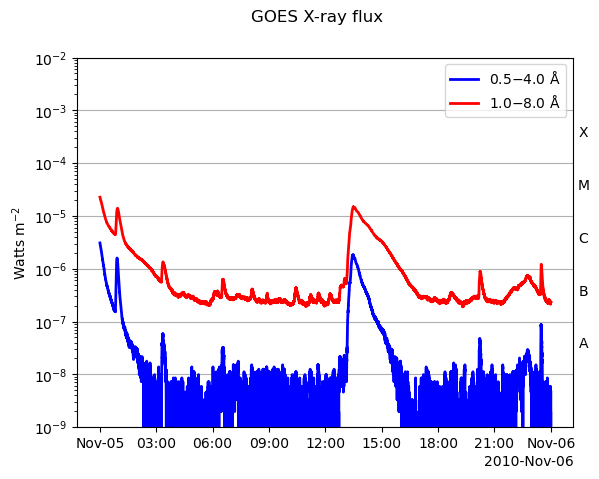

In [5]:
# Descargar los datos de un día
goes_ts = Download_Data(start_time, end_time)


### Trunca los datos del flare

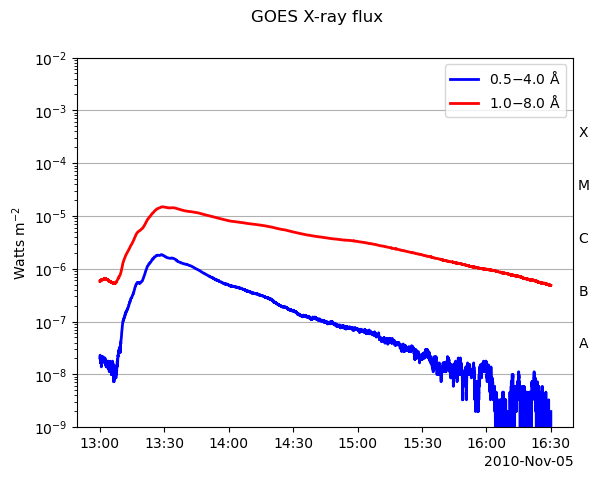

In [6]:
# Truncar datos al tiempo del flare
goes_flare = Truncate_Data(goes_ts, flare_start_time, flare_end_time)

### Vamos a calcular el background

In [7]:
#prueba
#go_background = 4e-07

2025-04-21 12:16:16 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.


Valor de background banda xrsa: 7.233548870999584e-09
valor de flare_start_index: 0


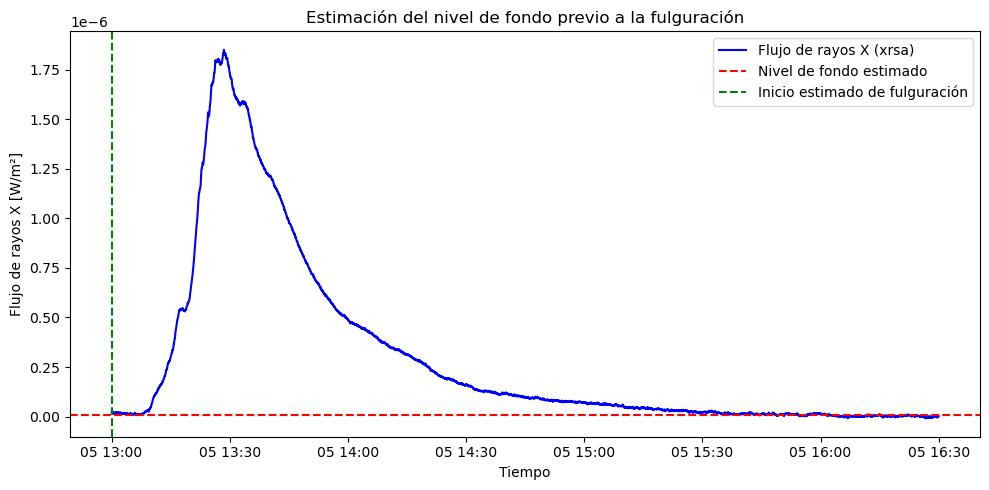

In [8]:
go_background_a = go_background(goes_flare, flare_start_time, channel='xrsa', window_minutes=10)

2025-04-21 12:16:16 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.


Valor de background banda xrsb: 5.207356252867612e-07
valor de flare_start_index: 0


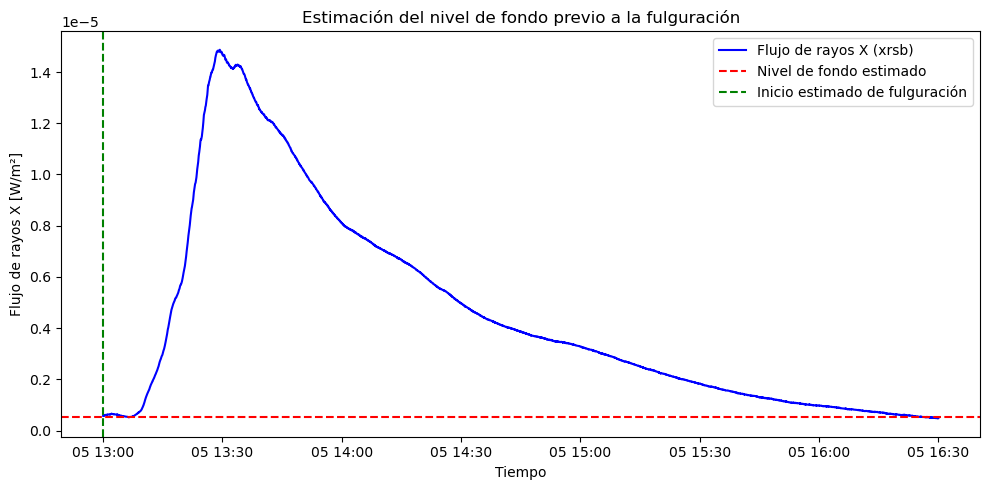

In [9]:
go_background_b = go_background(goes_flare, flare_start_time, channel='xrsb', window_minutes=10)

### Resta de Background

In [10]:
#goes_flare_corrected = Goes_Background(goes_flare, go_background_a = 4.601101277756925e-09, go_background_b = 4.492276843848231e-07)
#goes_flare_corrected = Goes_Background(goes_flare, 4.601101277756925e-09,  4.492276843848231e-07)
goes_flare_corrected = Goes_Background(goes_flare, go_background_a, go_background_b, scaling_factor_a=0.85, scaling_factor_b=0.7)

2025-04-21 12:16:17 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.
2025-04-21 12:16:17 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.


Extraer los datos de rayos X blandos y duros:
                                 xrsa          xrsb  xrsa_quality  \
2010-11-05 13:00:01.305  2.039579e-08  5.809528e-07             0   
2010-11-05 13:00:03.351  2.171201e-08  5.809528e-07             0   
2010-11-05 13:00:05.401  2.302823e-08  5.884800e-07             0   
2010-11-05 13:00:07.448  2.302823e-08  5.809528e-07             0   
2010-11-05 13:00:09.495  1.907956e-08  5.922436e-07             0   
...                               ...           ...           ...   
2010-11-05 16:29:50.215  6.524298e-10  4.868634e-07             0   
2010-11-05 16:29:52.261  6.524298e-10  4.793363e-07             0   
2010-11-05 16:29:54.308  6.524298e-10  4.868634e-07             0   
2010-11-05 16:29:56.358 -6.637940e-10  4.793363e-07             0   
2010-11-05 16:29:58.405  1.968654e-09  4.830999e-07             0   

                         xrsb_quality  
2010-11-05 13:00:01.305             0  
2010-11-05 13:00:03.351             0  
2010-

### Cálculo T y EM

In [11]:
#Calcular temperatura y medida de emisión con los datos corregidos
temp_em = Calculate_Tem_EM (goes_flare_corrected)


Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.12s/file]
/home/paula/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


### Gráficas

/tmp/ipykernel_5255/3808426115.py:221: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = plt.scatter(medida_em_filtrada[mascara_coloreados],


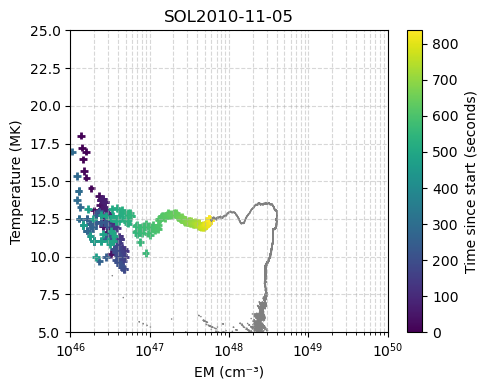

In [12]:
#gráficas
Graphics_T_EM(goes_flare_corrected, temp_em, time_colors, title)

## SOL2011-02-14 T01:37 B9.4

### Datos del flare

In [13]:
#  Definir el día de la fulguración

start_time = "2011-02-14 00:00:00"
end_time = "2011-02-14 23:59:00"


In [14]:
# Definir tiempo de flare
flare_start_time = "2011-02-14 01:20:00"
flare_end_time = "2011-02-14 01:50:00"
time_colors = "2011-02-14 01:38:00" # tiempo hasta el que se grafica en escala de color

title = "SOL2011-02-14" 

### Descargar los datos del día

2025-04-21 12:16:37 - sunpy - WARNING: SunpyConnectionWarning: Connection to http://docs.virtualsolar.org/WSDL/VSOi_rpc_literal.wsdl failed with error <urlopen error [Errno -3] Temporary failure in name resolution>. Retrying with different url and port.
2025-04-21 12:16:38 - zeep.wsdl.bindings.soap - WARNING: Forcing soap:address location to HTTPS
2025-04-21 12:16:41 - zeep.wsdl.bindings.soap - WARNING: Forcing soap:address location to HTTPS
Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  3.35file/s]


SunPy TimeSeries
----------------
Observatory:			GOES-15
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2011-02-14 00:00:01
End Date:			2011-02-14 23:59:59
Center Date:			2011-02-14 11:59:59
Resolution:			2.048 s
Samples per Channel:		42188
Data Range(s):		xrsa           6.04E-06<br>xrsb           3.27E-05<br>xrsa_quality   6.40E+01<br>xrsb_quality   6.40E+01
Units:			dimensionless<br>W / m2
                                 xrsa          xrsb  xrsa_quality  \
2011-02-14 00:00:00.978  1.422231e-08  7.922259e-07             0   
2011-02-14 00:00:03.028  1.553852e-08  7.884623e-07             0   
2011-02-14 00:00:05.075  1.553852e-08  7.922259e-07             0   
2011-02-14 00:00:07.125  1.553852e-08  7.884623e-07             0   
2011-02-14 00:00:09.171  1.817093e-08  7.884623e-07             0   
...                               ...           ...           ..

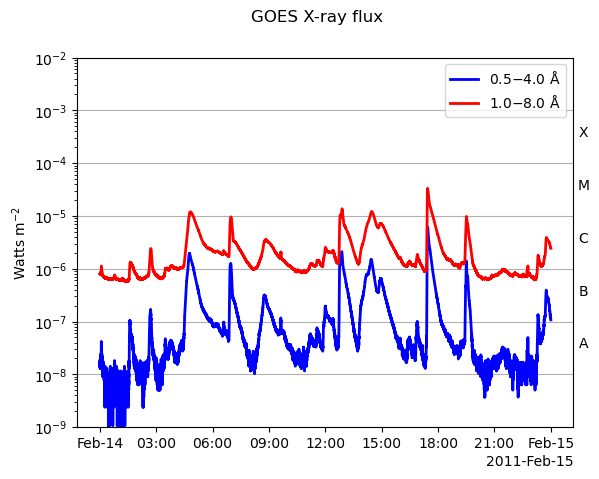

In [15]:
# Descargar los datos de un día
goes_ts = Download_Data(start_time, end_time)

### Truncar los datos del flare

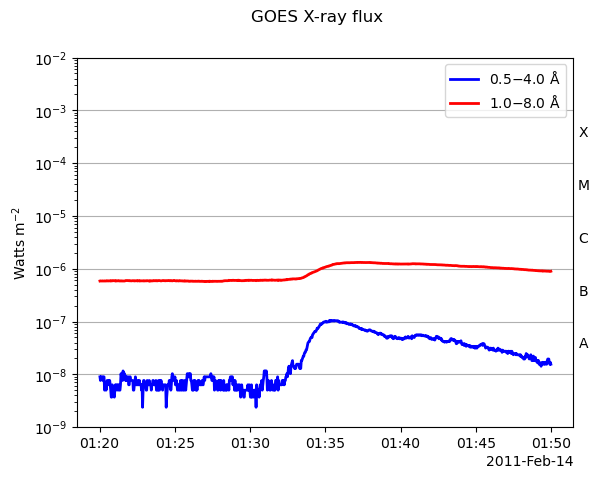

In [16]:
# Truncar datos al tiempo del flare
goes_flare = Truncate_Data(goes_ts, flare_start_time, flare_end_time)

### Calculo de background

2025-04-21 12:16:47 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.


Valor de background banda xrsa: 2.376463914544047e-09
valor de flare_start_index: 0


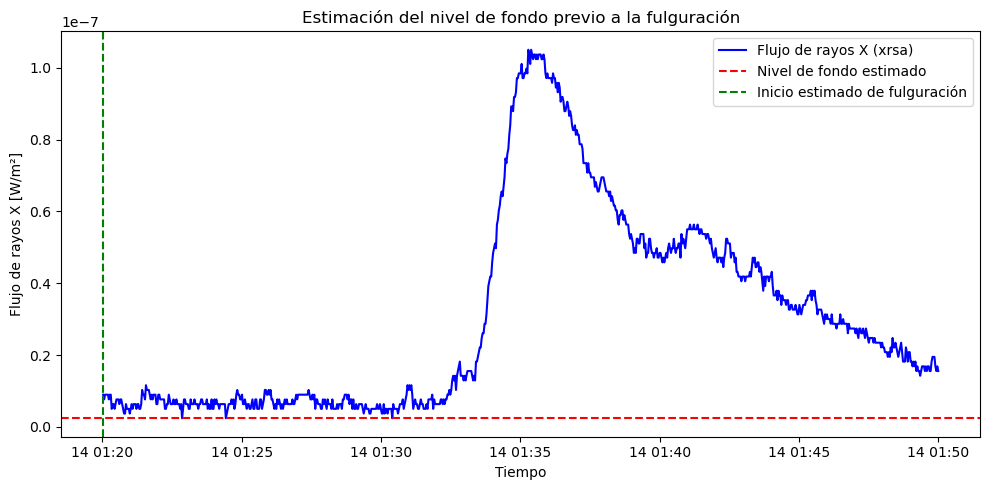

In [17]:
go_background_a = go_background(goes_flare, flare_start_time, channel='xrsa', window_minutes=10)

2025-04-21 12:16:47 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.


Valor de background banda xrsb: 5.701749046238547e-07
valor de flare_start_index: 0


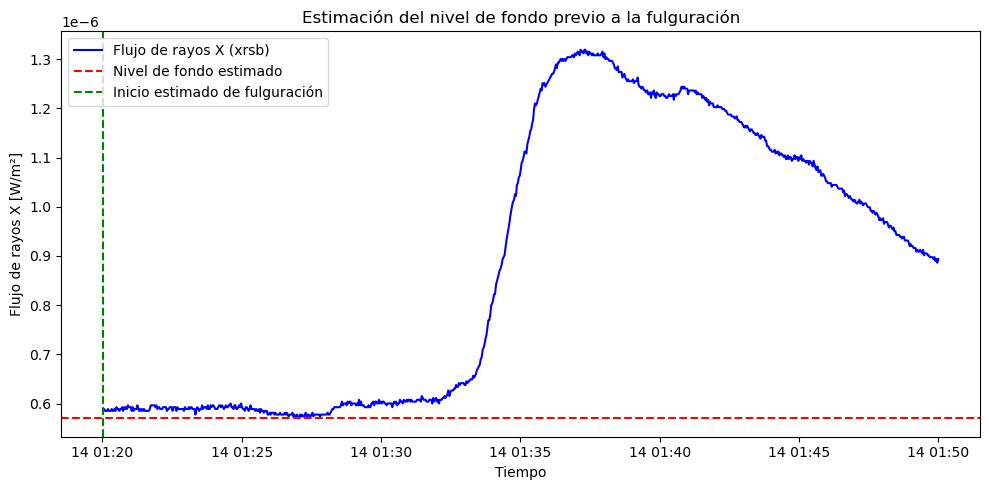

In [18]:
go_background_b = go_background(goes_flare, flare_start_time, channel='xrsb', window_minutes=10)

### Resta de background

In [19]:
goes_flare_corrected = Goes_Background(goes_flare, go_background_a, go_background_b, scaling_factor_a=0.85, scaling_factor_b=0.7)

2025-04-21 12:16:48 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.
2025-04-21 12:16:48 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.


Extraer los datos de rayos X blandos y duros:
                                 xrsa          xrsb  xrsa_quality  \
2011-02-14 01:20:01.425  8.957493e-09  5.852293e-07             0   
2011-02-14 01:20:03.471  7.641287e-09  5.889928e-07             0   
2011-02-14 01:20:05.521  8.957493e-09  5.852293e-07             0   
2011-02-14 01:20:07.568  8.957493e-09  5.852293e-07             0   
2011-02-14 01:20:09.615  8.957493e-09  5.852293e-07             0   
...                               ...           ...           ...   
2011-02-14 01:49:51.351  1.948714e-08  8.976061e-07             0   
2011-02-14 01:49:53.398  1.685473e-08  8.900789e-07             0   
2011-02-14 01:49:55.448  1.553852e-08  8.938425e-07             0   
2011-02-14 01:49:57.495  1.685473e-08  8.863153e-07             0   
2011-02-14 01:49:59.545  1.553852e-08  8.938425e-07             0   

                         xrsb_quality  
2011-02-14 01:20:01.425             0  
2011-02-14 01:20:03.471             0  
2011-

### Calculo T y EM

In [20]:
#Calcular temperatura y medida de emisión con los datos corregidos
temp_em = Calculate_Tem_EM (goes_flare_corrected)

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.20file/s]
/home/paula/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


### Gráficas

/tmp/ipykernel_5255/3808426115.py:221: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = plt.scatter(medida_em_filtrada[mascara_coloreados],


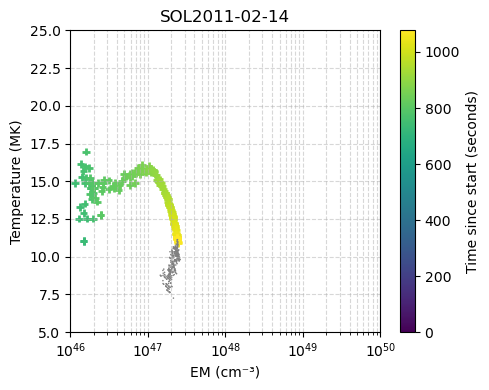

In [21]:
# Gráficas
Graphics_T_EM(goes_flare_corrected, temp_em, time_colors, title)

## SOL2012-05-14 T13:38 C1.1

### Datos del flare

In [22]:
#  Definir el día de la fulguración

start_time = "2012-05-14 00:00:00"
end_time = "2012-05-14 23:59:00"


In [23]:
# Definir tiempo de flare
flare_start_time = "2012-05-14 13:30:00"
flare_end_time = "2012-05-14 13:45:00"
time_colors = "2012-05-14 13:41:00" # tiempo hasta el que se grafica en escala de color

title = "SOL2012-05-14" 

### Descargar los datos del día

2025-04-21 12:17:07 - sunpy - WARNING: SunpyConnectionWarning: Connection to http://docs.virtualsolar.org/WSDL/VSOi_rpc_literal.wsdl failed with error <urlopen error [Errno -3] Temporary failure in name resolution>. Retrying with different url and port.
2025-04-21 12:17:08 - zeep.wsdl.bindings.soap - WARNING: Forcing soap:address location to HTTPS
2025-04-21 12:17:11 - zeep.wsdl.bindings.soap - WARNING: Forcing soap:address location to HTTPS
Files Downloaded: 100%|██████████| 2/2 [00:00<00:00,  3.32file/s]


SunPy TimeSeries
----------------
Observatory:			GOES-15
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2012-05-14 00:00:01
End Date:			2012-05-15 00:00:00
Center Date:			2012-05-14 12:00:00
Resolution:			2.049 s
Samples per Channel:		42159
Data Range(s):		xrsa           6.05E-07<br>xrsb           5.40E-06<br>xrsa_quality   6.40E+01<br>xrsb_quality   6.40E+01
Units:			dimensionless<br>W / m2
                                 xrsa          xrsb  xrsa_quality  \
2012-05-14 00:00:01.365  4.776752e-09  5.564829e-07             0   
2012-05-14 00:00:03.411  6.092956e-09  5.527193e-07             0   
2012-05-14 00:00:05.461  4.776752e-09  5.527193e-07             0   
2012-05-14 00:00:07.508  7.409160e-09  5.527193e-07             0   
2012-05-14 00:00:09.555  3.460548e-09  5.564829e-07             0   
...                               ...           ...           ..

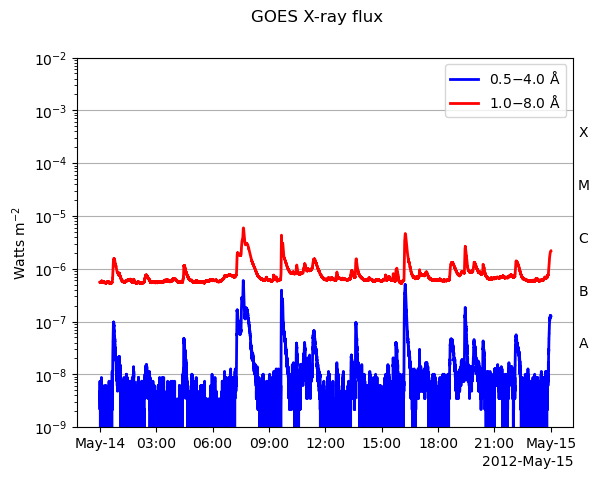

In [24]:
# Descargar los datos de un día
goes_ts = Download_Data(start_time, end_time)

### Truncar los datos del flare

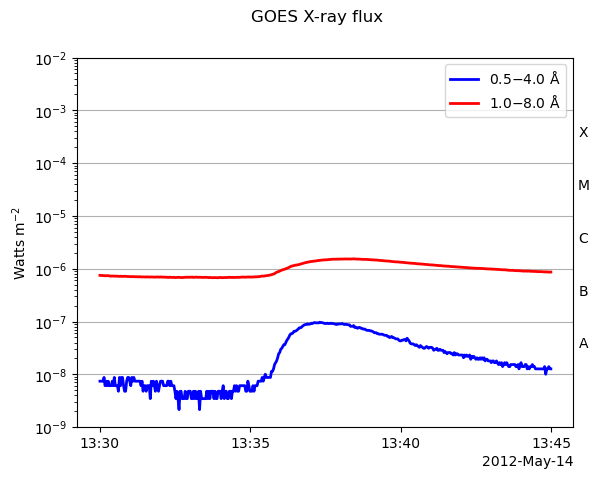

In [25]:
# Truncar datos al tiempo del flare
goes_flare = Truncate_Data(goes_ts, flare_start_time, flare_end_time)

### Calculo de background

2025-04-21 12:17:17 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.


Valor de background banda xrsa: 2.1443442577151473e-09
valor de flare_start_index: 0


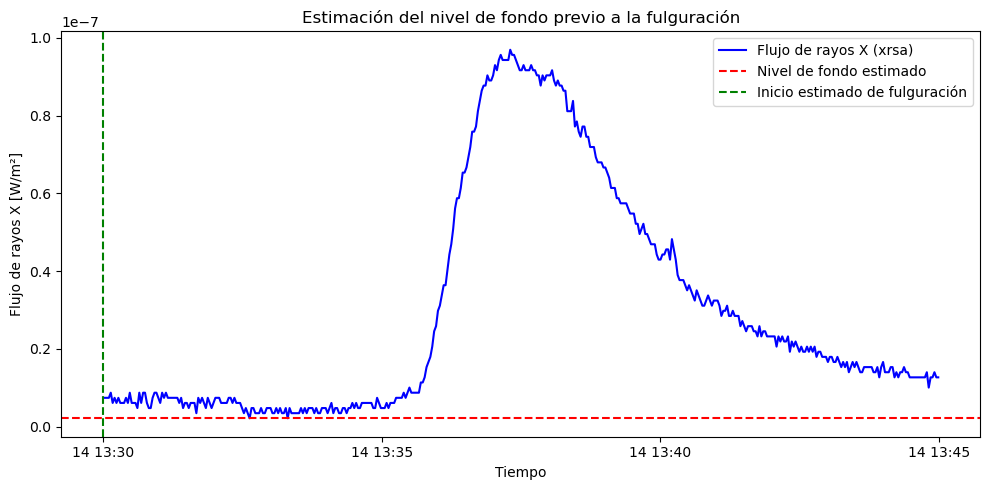

In [26]:
go_background_a = go_background(goes_flare, flare_start_time, channel='xrsa', window_minutes=10)

2025-04-21 12:17:18 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.


Valor de background banda xrsb: 6.731537496307283e-07
valor de flare_start_index: 0


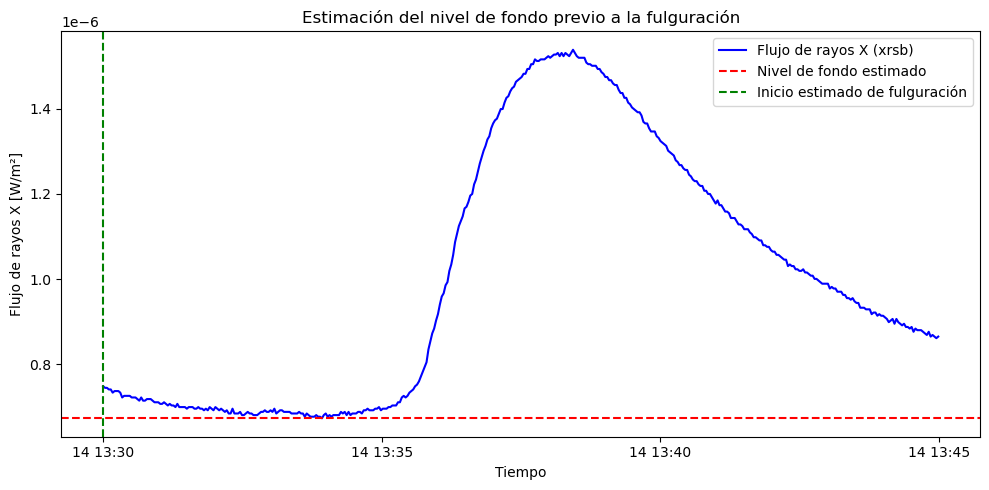

In [27]:
go_background_b = go_background(goes_flare, flare_start_time, channel='xrsb', window_minutes=10)

### Resta de background

In [28]:
goes_flare_corrected = Goes_Background(goes_flare, go_background_a, go_background_b, scaling_factor_a=0.85, scaling_factor_b=0.7)

2025-04-21 12:17:19 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.
2025-04-21 12:17:19 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.


Extraer los datos de rayos X blandos y duros:
                                 xrsa          xrsb  xrsa_quality  \
2012-05-14 13:30:00.018  7.409160e-09  7.484252e-07             0   
2012-05-14 13:30:02.068  7.409160e-09  7.446617e-07             0   
2012-05-14 13:30:04.115  7.409160e-09  7.446617e-07             0   
2012-05-14 13:30:06.165  7.409160e-09  7.408981e-07             0   
2012-05-14 13:30:08.211  8.725364e-09  7.408981e-07             0   
...                               ...           ...           ...   
2012-05-14 13:44:50.885  1.267398e-08  8.650961e-07             0   
2012-05-14 13:44:52.935  1.267398e-08  8.688597e-07             0   
2012-05-14 13:44:54.981  1.399018e-08  8.650961e-07             0   
2012-05-14 13:44:57.028  1.267398e-08  8.613325e-07             0   
2012-05-14 13:44:59.078  1.267398e-08  8.650961e-07             0   

                         xrsb_quality  
2012-05-14 13:30:00.018             0  
2012-05-14 13:30:02.068             0  
2012-

### Calculo T y EM

In [29]:
#Calcular temperatura y medida de emisión con los datos corregidos
temp_em = Calculate_Tem_EM (goes_flare_corrected)

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.09file/s]
/home/paula/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


### Gráficas

/tmp/ipykernel_5255/3808426115.py:221: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = plt.scatter(medida_em_filtrada[mascara_coloreados],


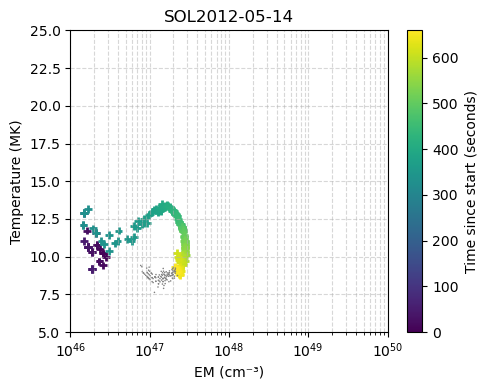

In [30]:
# Gráficas
Graphics_T_EM(goes_flare_corrected, temp_em, time_colors, title)

## SOL2014-01-07 T10:13 M7.3

### Datos del flare

In [31]:
#  Definir el día de la fulguración

start_time = "2014-01-07 00:00:00"
end_time = "2014-01-07 23:59:00"

In [32]:
# Definir tiempo de flare
flare_start_time = "2014-01-07 10:00:00"
flare_end_time = "2014-01-07 11:30:00"
time_colors = "2014-01-07 10:15:00" # tiempo hasta el que se grafica en escala de color

title = "SOL2014-01-07"

### Descargar los datos del día

2025-04-21 12:17:34 - sunpy - WARNING: SunpyConnectionWarning: Connection to http://docs.virtualsolar.org/WSDL/VSOi_rpc_literal.wsdl failed with error <urlopen error [Errno -3] Temporary failure in name resolution>. Retrying with different url and port.
2025-04-21 12:17:36 - zeep.wsdl.bindings.soap - WARNING: Forcing soap:address location to HTTPS
2025-04-21 12:17:38 - zeep.wsdl.bindings.soap - WARNING: Forcing soap:address location to HTTPS
Files Downloaded: 100%|██████████| 4/4 [00:01<00:00,  2.77file/s]


SunPy TimeSeries
----------------
Observatory:			GOES-13
Instrument:			<a href=https://www.swpc.noaa.gov/products/goes-x-ray-flux target="_blank">Unknown</a>
Channel(s):			xrsa<br>xrsb<br>xrsa_quality<br>xrsb_quality
Start Date:			2014-01-07 00:00:01
End Date:			2014-01-08 00:00:00
Center Date:			2014-01-07 12:00:00
Resolution:			2.048 s
Samples per Channel:		42183
Data Range(s):		xrsa           3.37E-05<br>xrsb           2.06E-04<br>xrsa_quality   6.40E+01<br>xrsb_quality   6.40E+01
Units:			dimensionless<br>W / m2
                                 xrsa      xrsb  xrsa_quality  xrsb_quality
2014-01-07 00:00:00.685  1.446068e-08  0.000002             0             0
2014-01-07 00:00:02.735  1.510977e-08  0.000002             0             0
2014-01-07 00:00:04.781  1.446068e-08  0.000002             0             0
2014-01-07 00:00:06.831  1.510977e-08  0.000002             0             0
2014-01-07 00:00:08.878  1.575888e-08  0.000002             0             0
...                   

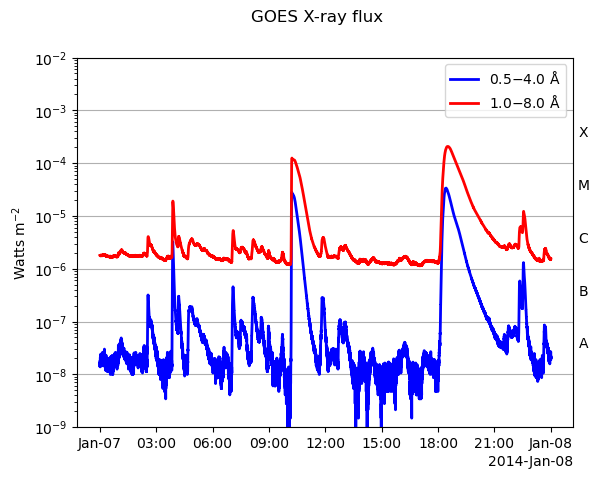

In [33]:
# Descargar los datos de un día
goes_ts = Download_Data(start_time, end_time)

### Truncar los datos del flare

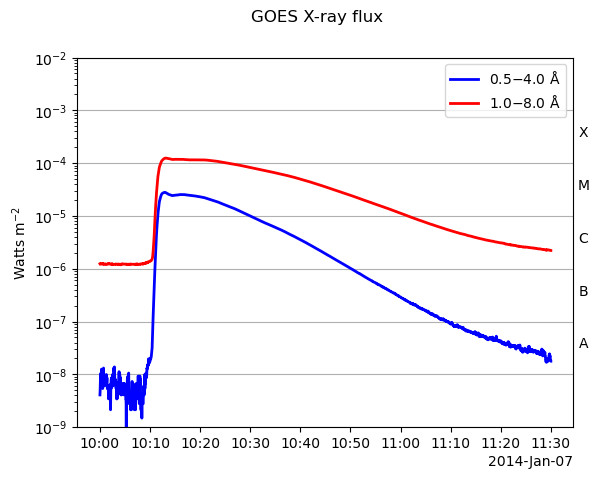

In [34]:
# Truncar datos al tiempo del flare
goes_flare = Truncate_Data(goes_ts, flare_start_time, flare_end_time)

### Calculo de background

2025-04-21 12:17:44 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.


Valor de background banda xrsa: 1.8047698058243355e-10
valor de flare_start_index: 0


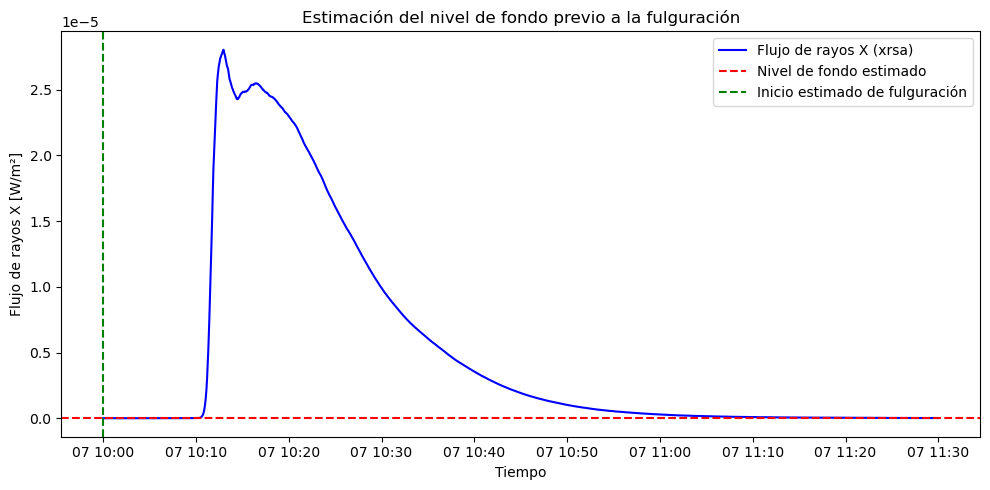

In [35]:
go_background_a = go_background(goes_flare, flare_start_time, channel='xrsa', window_minutes=10)

2025-04-21 12:17:45 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.


Valor de background banda xrsb: 1.1856640185214928e-06
valor de flare_start_index: 0


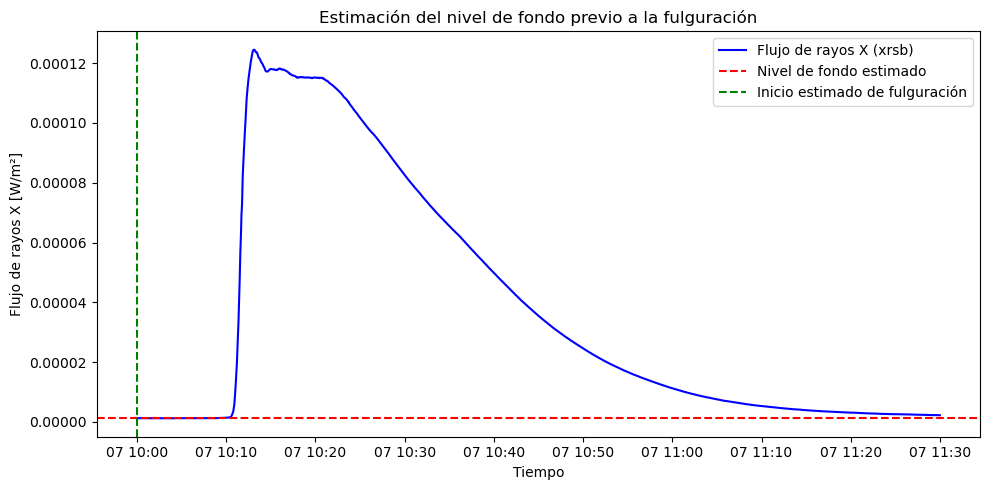

In [36]:
go_background_b = go_background(goes_flare, flare_start_time, channel='xrsb', window_minutes=10)

### Resta de background

In [37]:
goes_flare_corrected = Goes_Background(goes_flare, go_background_a, go_background_b, scaling_factor_a=0.85, scaling_factor_b=0.7)

2025-04-21 12:17:46 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.
2025-04-21 12:17:46 - sunpy - WARNING: SunpyUserWarning: Using .data to access the dataframe is discouraged; use .to_dataframe() instead.


Extraer los datos de rayos X blandos y duros:
                                 xrsa      xrsb  xrsa_quality  xrsb_quality
2014-01-07 10:00:00.345  4.075077e-09  0.000001             0             0
2014-01-07 10:00:02.391  4.724177e-09  0.000001             0             0
2014-01-07 10:00:04.438  7.320576e-09  0.000001             0             0
2014-01-07 10:00:06.488  8.618776e-09  0.000001             0             0
2014-01-07 10:00:08.535  9.267876e-09  0.000001             0             0
...                               ...       ...           ...           ...
2014-01-07 11:29:50.651  2.224987e-08  0.000002             0             0
2014-01-07 11:29:52.698  1.965348e-08  0.000002             0             0
2014-01-07 11:29:54.748  1.900437e-08  0.000002             0             0
2014-01-07 11:29:56.795  1.770617e-08  0.000002             0             0
2014-01-07 11:29:58.845  1.770617e-08  0.000002             0             0

[2637 rows x 4 columns]
vamos a restar el

### Calculo T y EM


In [38]:
#Calcular temperatura y medida de emisión con los datos corregidos
temp_em = Calculate_Tem_EM (goes_flare_corrected)

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.19file/s]
/home/paula/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


### Gráficas

/tmp/ipykernel_5255/3808426115.py:221: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc = plt.scatter(medida_em_filtrada[mascara_coloreados],


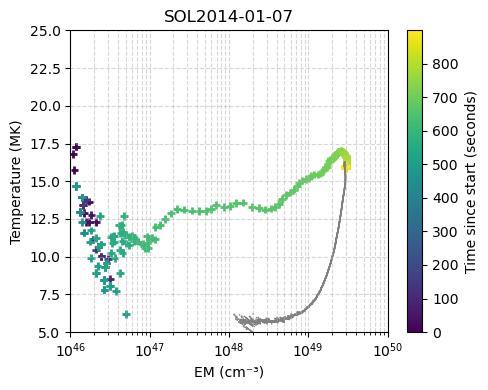

In [39]:
# Gráficas
Graphics_T_EM(goes_flare_corrected, temp_em, time_colors, title)